In [1]:
import numpy as np
import blip_analysis as ba
import matplotlib.pyplot as plt
import pickle
import scipy
from tqdm import trange
from matplotlib.gridspec import GridSpec
from label_axes import label_axes
import dask
import daskify
from scipy.optimize import minimize

b


In [3]:
dasked = daskify.Daskified(memory='16GB', size=15)
dasked.start_cluster()

/camp/home/warnert/.conda/envs/blip_manu/lib/python3.7/site-packages/distributed/node.py:155: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 42766 instead
  http_address["port"], self.http_server.port


In [12]:
unit_usrt1, unit_usrt2, unit_usrt3 = ba.load_usrts()
good_indexes = ba.get_stable_resp_indexes()
glyphs = ba.get_glyphs()

Found odour 1
Found odour 3
Found odour 5


In [2]:
diff_models1 = pickle.Unpickler(open('../Fig4/230320_diff_models1.pkl', 'rb')).load()
diff_models2 = pickle.Unpickler(open('../Fig4/230320_diff_models2.pkl', 'rb')).load()
diff_models3 = pickle.Unpickler(open('../Fig4/230320_diff_models3.pkl', 'rb')).load()
model_length = 130

In [3]:
### Loading responsive cells from the 230509_fig5_2PCs.ipynb - only cells which are 'responsive' to all three odours
responsive_only_cells = np.load('../Fig5/230515_all_responsive_cells.npy')
diff_models1 = diff_models1[responsive_only_cells]
diff_models2 = diff_models2[responsive_only_cells]
diff_models3 = diff_models3[responsive_only_cells]
model_length = 66

In [4]:
[i.fit() for i in diff_models1];
[i.fit() for i in diff_models2];
[i.fit() for i in diff_models3];

In [6]:
### Load in the other odour fit results (this takes the 66 responsive cells)
res = np.load('../Figs_to_give/Data/230704_other_odour_fits.npy', allow_pickle=True)

In [7]:
## reshaping
cell_preds12 = res[0, 0, :, 0, :]
scores12 = res[0, 0, :, 1, :]
cell_preds13 = res[0, 1, :, 0, :]
scores13 = res[0, 1, :, 1, :]
cell_preds21 = res[1, 0, :, 0, :]
scores21 = res[1, 0, :, 1, :]
cell_preds23 = res[1, 1, :, 0, :]
scores23 = res[1, 1, :, 1, :]
cell_preds31 = res[2, 0, :, 0, :]
scores31 = res[2, 0, :, 1, :]
cell_preds32 = res[2, 1, :, 0, :]
scores32 = res[2, 1, :, 1, :]

In [8]:
diff_ws1 = [i.opt_out.x[:-1] for i in diff_models1]
diff_ws2 = [i.opt_out.x[:-1] for i in diff_models2]
diff_ws3 = [i.opt_out.x[:-1] for i in diff_models3]

preds1 = [i.pred_resp for i in diff_models1]
preds2 = [i.pred_resp for i in diff_models2]
preds3 = [i.pred_resp for i in diff_models3];

trues1 = [i.true_resp for i in diff_models1]
trues2 = [i.true_resp for i in diff_models2]
trues3 = [i.true_resp for i in diff_models3];

In [13]:
mean_usrt1 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
std_usrt1 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt1[good_indexes][responsive_only_cells]]
mean_usrt2 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
std_usrt2 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt2[good_indexes][responsive_only_cells]]
mean_usrt3 = [[np.mean(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]
std_usrt3 = [[np.std(np.mean(i, axis=-1)) for i in j] for j in unit_usrt3[good_indexes][responsive_only_cells]]

In [10]:
diff_models_scattered1 = dasked.client.scatter(diff_models1)
diff_models_scattered2 = dasked.client.scatter(diff_models2)
diff_models_scattered3 = dasked.client.scatter(diff_models3)

diff_ws_scattered1 = dasked.client.scatter(diff_ws1)
diff_ws_scattered2 = dasked.client.scatter(diff_ws2)
diff_ws_scattered3 = dasked.client.scatter(diff_ws3)

In [22]:
print(type(diff_models2))

<class 'numpy.ndarray'>


In [23]:
model = diff_models1[0]
model.fit(W=diff_ws2[0])

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 8 is different from 9)

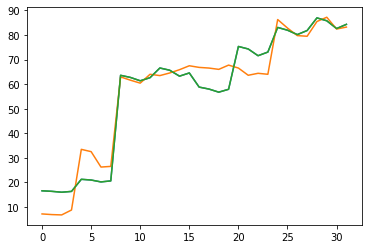

In [ ]:
ui = 40
model = diff_models1[ui]
#model.fit(W=diff_ws2[ui])
plt.plot(model.pred_resp)
plt.plot(model.true_resp)
plt.plot(preds1[ui])

In [11]:
def other_odour_loss(ats, model, weights):
    #print(weights)
    changed_ws = weights*ats[0]
    changed_ws = np.append(changed_ws, ats[1])
    #print(changed_ws)
    model.fit(W=changed_ws)
    return model.loss(model.pred_resp, model.true_resp)

# ui = 70
# opt12 = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(diff_models1[ui], diff_ws2[ui]), method='Nelder-Mead')
# preds12 = [i.pred_resp for i in diff_models1];
# opt13 = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(diff_models1[ui], diff_ws3[ui]), method='Nelder-Mead')
# preds13 = [i.pred_resp for i in diff_models1];
# opt23 = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(diff_models2[ui], diff_ws3[ui]), method='Nelder-Mead')
# preds23 = [i.pred_resp for i in diff_models2];
# opt21 = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(diff_models2[ui], diff_ws1[ui]), method='Nelder-Mead')
# preds21 = [i.pred_resp for i in diff_models2];
# opt31 = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(diff_models3[ui], diff_ws1[ui]), method='Nelder-Mead')
# preds31 = [i.pred_resp for i in diff_models3];
# opt32 = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(diff_models3[ui], diff_ws2[ui]), method='Nelder-Mead')
# preds32 = [i.pred_resp for i in diff_models3];

In [12]:
def find_all_fits(models, alternative_ws, ui, tqdm=False):
    preds = []
    scores = []
    for i in trange(len(models), position=0, leave=False, disable=tqdm):
        opt = scipy.optimize.minimize(other_odour_loss, x0=np.ones(2), args=(models[ui], alternative_ws[i]), method='Nelder-Mead')
        appended = np.append(alternative_ws[i]*opt.x[0], opt.x[1])
        models[ui].fit(W=appended)
        preds.append(models[ui].pred_resp)
        fit_score = np.mean((models[ui].pred_resp - models[ui].true_resp)**2)/np.std(models[ui].true_resp)**2
        #print(models[ui].fit_score, fit_score)
        scores.append(models[ui].fit_score)

    return preds, scores

#cell_preds, scores = find_all_fits(diff_models1, diff_ws2, 40)


In [ ]:
cell_preds12 = []
scores12 = []
for ui in trange(130, position=0, leave=False):
    cps, scores = find_all_fits(diff_models1, diff_ws2, ui, tqdm=True)
    cell_preds12.append(cps)
    scores12.append(scores)
    

KeyboardInterrupt: 

In [ ]:
cell_preds13 = []
scores13 = []
for ui in trange(130, position=0, leave=False):
    cps, scores = find_all_fits(diff_models1, diff_ws3, ui, tqdm=True)
    cell_preds13.append(cps)
    scores13.append(scores)

In [13]:
dask_outs = []
weight_types = [[diff_ws_scattered2, diff_ws_scattered3], [diff_ws_scattered1, diff_ws_scattered3], [diff_ws_scattered1, diff_ws_scattered2]]

for index, model_type in enumerate([diff_models_scattered1, diff_models_scattered2, diff_models_scattered3]):
    for weights in weight_types[index]:
        for ui in range(model_length):
            dask_outs.append(dask.delayed(find_all_fits)(model_type, weights, ui, tqdm=False))
dask_futures = dasked.client.compute(dask_outs)
dasked.current_futures = dask_futures

In [27]:
dasked.check_progress()

finished 396


In [28]:
res = dasked.collect_results()

res = np.array(res)
res = res.reshape(3, 2, model_length, 2, model_length)

In [29]:
cell_preds12 = res[0, 0, :, 0, :]
scores12 = res[0, 0, :, 1, :]
cell_preds13 = res[0, 1, :, 0, :]
scores13 = res[0, 1, :, 1, :]


cell_preds21 = res[1, 0, :, 0, :]
scores21 = res[1, 0, :, 1, :]
cell_preds23 = res[1, 1, :, 0, :]
scores23 = res[1, 1, :, 1, :]
cell_preds31 = res[2, 0, :, 0, :]
scores31 = res[2, 0, :, 1, :]
cell_preds32 = res[2, 1, :, 0, :]
scores32 = res[2, 1, :, 1, :]

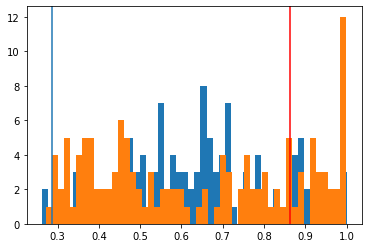

In [ ]:
# ui = 120
# plt.hist(scores12[ui], bins=50)
# plt.hist(scores13[ui], bins=50)
# plt.axvline(scores12[ui][ui])
# plt.axvline(scores13[ui][ui], color='r')


In [30]:
score_fracs12 = []
score_fracs13 = []
for i in range(model_length):
    self_score12 = scores12[i][i]
    self_score13 = scores13[i][i]
    score_fracs12.append(len(np.where(np.array(scores12)[i] < self_score12)[0])/model_length)
    score_fracs13.append(len(np.where(np.array(scores13)[i] < self_score13)[0])/model_length)
min_score_fracs = np.min([score_fracs12, score_fracs13], axis=0)
best_odour_fracs = np.array([score_fracs12, score_fracs13]).argmin(axis=0)


54
36
58
55
46
62
42
48
55


Text(0.5, 1.0, 'Odour 3')

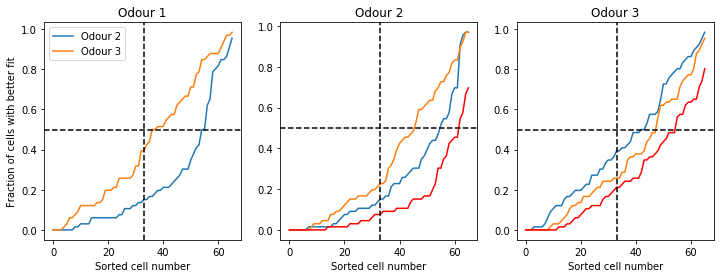

In [31]:
def plot_score_fracs(scores1, scores2, odour1_label='Odour 1', odour2_label='Odour 2', ax=None, colors=['C0', 'C1', 'r'], show_best=True):
    scores_frac1 = []
    scores_frac2 = []
    for i in range(model_length):
        self_score1 = scores1[i][i]
        self_score2 = scores2[i][i]
        scores_frac1.append(len(np.where(np.array(scores1)[i] < self_score1)[0])/model_length)
        scores_frac2.append(len(np.where(np.array(scores2)[i] < self_score2)[0])/model_length)
    min_score_fracs = np.min([scores_frac1, scores_frac2], axis=0)
    best_odour_fracs = np.array([scores_frac1, scores_frac2]).argmin(axis=0)

    frac_args1 = np.argsort(scores_frac1)
    frac_args2 = np.argsort(scores_frac2)
    minfracs_args = np.argsort(min_score_fracs)

    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.plot(np.array(scores_frac1)[frac_args1], label=odour1_label, color=colors[0])
    ax.plot(np.array(scores_frac2)[frac_args2], label=odour2_label, color=colors[1])
    if show_best:
        ax.plot(np.array(min_score_fracs)[minfracs_args], label='Min of both odours', color=colors[2])
    ax.axhline(0.5, color='k', linestyle='--')
    ax.set_xlabel('Sorted cell number')
    ax.set_ylabel('Fraction of cells with better fit')
    ax.axvline(int(model_length/2), color='k', linestyle='--')

    print(len(np.where(np.array(scores_frac1) < 0.5)[0]))
    print(len(np.where(np.array(scores_frac2) < 0.5)[0]))
    print(len(np.where(np.array(min_score_fracs) < 0.5)[0]))
    fracs = [len(np.where(np.array(scores_frac1) < 0.5)[0]), len(np.where(np.array(scores_frac2) < 0.5)[0]), len(np.where(np.array(min_score_fracs) < 0.5)[0])]
    joint_args = [frac_args1, frac_args2, minfracs_args]
    return ax, fracs, joint_args
fig, ax = plt.subplots(1, 3, figsize=(12, 4))
ax0, fracs1, sorted_args1 = plot_score_fracs(scores12, scores13, odour1_label='Odour 2', odour2_label='Odour 3', ax=ax[0], show_best=False)
ax1, fracs2, sorted_args2 = plot_score_fracs(scores21, scores23, odour1_label='Odour 1', odour2_label='Odour 3', ax=ax[1])
ax2, fracs3, sorted_args3 = plot_score_fracs(scores31, scores32, odour1_label='Odour 1', odour2_label='Odour 2', ax=ax[2])
ax0.legend()
ax1.set_ylabel(None)
ax2.set_ylabel(None)
ax0.set_title('Odour 1')
ax1.set_title('Odour 2')
ax2.set_title('Odour 3')

In [ ]:
print(np.array(sorted_args1).shape)

(3, 130)


In [ ]:
print(sorted)

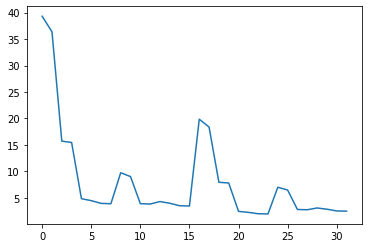

In [ ]:
plt.plot(cell_preds12[121][121])


Text(0.5, 1.0, 'Fraction of cells fit better by their response to another odour')

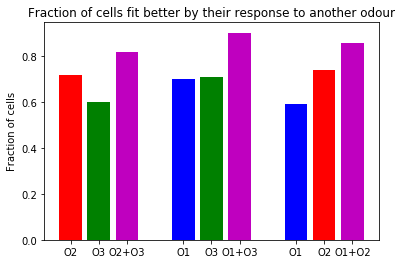

In [ ]:
plt.bar([0, 1, 2, 4, 5, 6, 8, 9, 10], np.array(fracs1+fracs2+fracs3)/model_length, color=['r', 'g', 'm', 'b', 'g', 'm', 'b', 'r', 'm'])
labels = ['O2', 'O3', 'O2+O3', 'O1', 'O3', 'O1+O3', 'O1', 'O2', 'O1+O2']
plt.xticks([0, 1, 2, 4, 5, 6, 8, 9, 10], labels=labels);
plt.ylabel('Fraction of cells')
plt.title('Fraction of cells fit better by their response to another odour')

In [ ]:
print(np.array(fracs1+fracs2+fracs3)/model_length)

[0.71538462 0.6        0.81538462 0.7        0.70769231 0.9
 0.59230769 0.73846154 0.85384615]


54
36
58


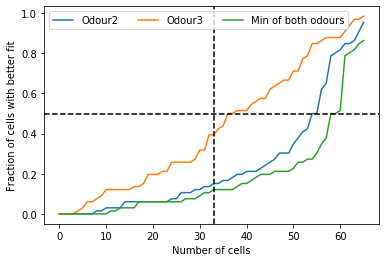

In [38]:
fracs_args12 = np.argsort(score_fracs12)
fracs_args13 = np.argsort(score_fracs13)
minfracs_args = np.argsort(min_score_fracs)
plt.plot(np.array(score_fracs12)[fracs_args12], label='Odour2')
plt.plot(np.array(score_fracs13)[fracs_args13], label='Odour3')
plt.plot(np.array(min_score_fracs)[minfracs_args], label='Min of both odours')
plt.axhline(0.5, linestyle='--', color='k')
print(len(np.where(np.array(score_fracs12) < 0.5)[0]))
print(len(np.where(np.array(score_fracs13) < 0.5)[0]))
print(len(np.where(np.array(min_score_fracs) < 0.5)[0]))
plt.xlabel('Number of cells')
plt.ylabel('Fraction of cells with better fit')
plt.legend(ncol=3)
plt.axvline(int(model_length/2), linestyle='--', color='k')

In [ ]:
print(minfracs_args[:20])
print(best_odour_fracs[:20])
print(minfracs_args[-10:])

[121  35  34  31 122  86  22  99 126  61 103 106   3 105  59  70   4  87
  50 112]
[1 1 0 0 0 0 1 1 0 0 1 0 0 0 1 1 0 1 0 1]
[ 30  98 113  28 110 101 124  63 128   9]


In [32]:
minfracs_args = sorted_args1[-1]

In [ ]:
np.save('230516_minfracs_args_all_responsive.npy', minfracs_args)

In [ ]:
minfracs_args = np.load('../Fig5/230516_minfracs_args_all_responsive.npy')

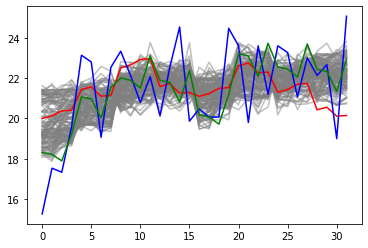

In [ ]:
ui = 30
cell_preds = cell_preds12[ui]
for i in range(130):
    if i != ui:
        plt.plot(cell_preds[i], color='gray', alpha=0.5)
plt.plot(cell_preds[ui], color='red', label='Odour 2 prediction')
plt.plot(diff_models1[ui].true_resp, color='blue', label='Odour 1 response')
plt.plot(preds1[ui], color='green', label='Odour 1 prediction')

NameError: name 'trues1' is not defined

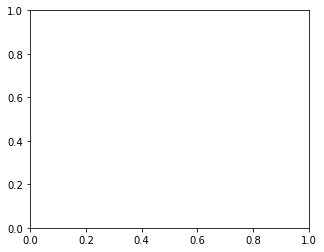

In [8]:
ui = 0
def plot_other_odour_prediction(true_resp, true_preds, other_odour_preds, ui, ax = None, legend=False, s=30, xs=np.arange(0, 32)):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot()
    print(np.vstack(other_odour_preds[ui]).shape)
    ax.boxplot(np.vstack(other_odour_preds[ui]), showfliers=False, positions=xs)
    #ax.boxplot(np.array(other_odour_preds[ui]).T)
    # for i in range(len(other_odour_preds)):
    #     if i != ui:
    #         ax.plot(other_odour_preds[ui][i], '.', color='gray', alpha=0.5)
    ax.scatter(xs, true_resp[ui], marker='o',  color='C0', label='True response', zorder=10, s=s)
    ax.scatter(xs, true_preds[ui], marker='o', color='C2', label='Model prediction', zorder=10, s=s)
    ax.scatter(xs, other_odour_preds[ui][ui], marker='o',color='C3', label='Other odour prediction', zorder=10, s=s)
    if legend:
        ax.legend()
    ax.set_xticks(xs)
    ax.set_xticklabels(glyphs, rotation=90)

def plot_double_odour_prediction(fig, ax, true_resp, true_preds, odourA_preds, odourB_preds, diff_models, odourA_scores, odourB_scores, ui):

#fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4), sharey=True)

    plot_other_odour_prediction(true_resp, true_preds, odourA_preds, ui, ax[0])
    plot_other_odour_prediction(true_resp, true_preds, odourB_preds, ui, ax[1])

    # print(diff_models1[ui].fit_score, scores12[ui][ui], scores13[ui][ui], np.median(scores12[ui]), np.median(scores13[ui]))
    # print(scipy.stats.percentileofscore(scores12[ui], scores12[ui][ui]))
    # print(scipy.stats.percentileofscore(scores13[ui], scores13[ui][ui]))

    title_ax = fig.add_subplot(111, frameon=False)
    title_ax.set_xticks([])
    title_ax.set_yticks([])
    percentilescore1 = scipy.stats.percentileofscore(odourA_scores[ui], odourA_scores[ui][ui])
    percentilescore2 = scipy.stats.percentileofscore(odourB_scores[ui], odourB_scores[ui][ui])
    title_ax.set_title(f'Full fit: {diff_models[ui].fit_score:0.2f}, odour 2 fit: {odourA_scores[ui][ui]:0.2f}, odour 3 fit: {odourB_scores[ui][ui]:0.2f}, percentile o2: {percentilescore1:0.2f}, percentile o3: {percentilescore2:0.2f}')
    title_ax.set_ylabel('Firing rate (Hz)', labelpad=20)
    title_ax.set_xlabel('Stimuli', labelpad=50)

def plot_other_odour_prediction_vio(true_resp, true_preds, other_odour_preds, ui, ax=None):
    mean_guess = np.mean(np.vstack(other_odour_preds[ui]), axis=0)
    yerr = (mean_guess - np.vstack(other_odour_preds[ui]).min(axis=0), np.vstack(other_odour_preds[ui]).max(axis=0)-mean_guess)
    print(yerr)
    ax.errorbar(range(32), np.mean(np.vstack(other_odour_preds[ui]), axis=0), fmt='s', yerr=yerr, color='k', label='Mean general prediction', alpha=0.5)
    ax.scatter(range(32), true_resp[ui], marker='o',  color='k', label='True response', zorder=10, s=30)
    ax.scatter(range(32), true_preds[ui], marker='v', color='k', label='True prediction', zorder=10)
    ax.scatter(range(32), other_odour_preds[ui][ui], marker='x',color='k', label='Other odour prediction', zorder=10)

fig, ax = plt.subplots(1, 1, figsize=(5, 4))
# plot_double_odour_prediction(fig, ax, trues1, preds1, cell_preds12, cell_preds13, diff_models1, scores12, scores13, 0)
plot_other_odour_prediction_vio(trues1, preds1, cell_preds12, minfracs_args[1], ax)
ax.legend()
#plot_other_odour_prediction(trues1, preds1, cell_preds12, 0, ax, legend=True)

In [ ]:
for ui in minfracs_args[:5]:
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4), sharey=True)
    plot_double_odour_prediction(fig, ax, trues1, preds1, cell_preds12, cell_preds13, diff_models1, scores12, scores13, ui)
    ax[0].legend()

for ui in minfracs_args[-5:]:
    fig, ax = plt.subplots(1, 2, sharex=True, figsize=(10, 4), sharey=True)
    plot_double_odour_prediction(fig, ax, trues1, preds1, cell_preds12, cell_preds13, diff_models1, scores12, scores13, ui)
    ax[0].legend()

NameError: name 'minfracs_args' is not defined

Text(0, 0.5, 'Normalised fit score')

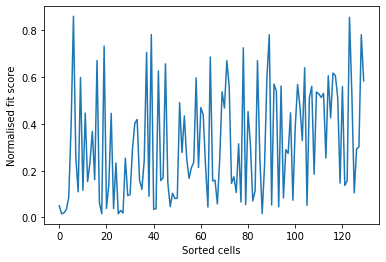

In [ ]:
resp_cells_base_fit = [i.fit_score for i in diff_models1[minfracs_args]]
plt.plot(resp_cells_base_fit)
plt.xlabel('Sorted cells')
plt.ylabel('Normalised fit score')

In [ ]:
print()

In [ ]:
print(np.corrcoef(np.arange(66), resp_cells_base_fit))

[[1.         0.33028234]
 [0.33028234 1.        ]]


NameError: name 'plot_other_odour_prediction' is not defined

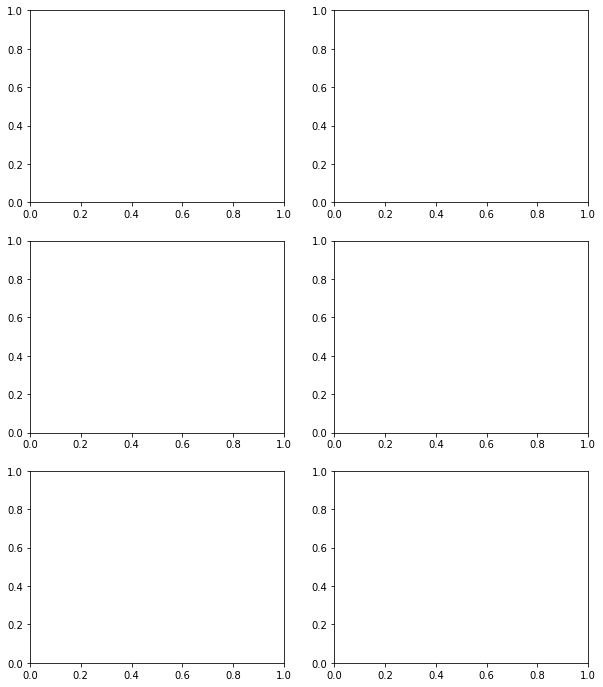

In [33]:
def set_global_ylim(axs):
    ylims = []
    for ax in axs:
        ylims.append(ax.get_ylim())
    ylims = np.array(ylims)
    for ax in axs:
        ax.set_ylim([np.min(ylims[:, 0]), np.max(ylims[:, 1])])

fig, ax = plt.subplots(3, 2, figsize=(10, 12))

ui = minfracs_args[-3]

plot_other_odour_prediction(trues1, preds1, cell_preds12, ui, ax=ax[0, 0])
plot_other_odour_prediction(trues1, preds1, cell_preds13, ui, ax=ax[0, 1], legend=True)
plot_other_odour_prediction(trues2, preds2, cell_preds21, ui, ax=ax[1, 0])
plot_other_odour_prediction(trues2, preds2, cell_preds23, ui, ax=ax[1, 1])
plot_other_odour_prediction(trues3, preds3, cell_preds31, ui, ax=ax[2, 0])
plot_other_odour_prediction(trues3, preds3, cell_preds32, ui, ax=ax[2, 1])

[i.set_xticklabels([]) for i in ax[:-1, :].flatten()];

oA_scores = [scores12, scores21, scores31]
oB_scores = [scores13, scores23, scores32]
all_diff_models = [diff_models1, diff_models2, diff_models3]
oA_labels = [2, 1, 1]
oB_labels = [3, 3, 2]

for i in range(3):
    odourA_scores = oA_scores[i]
    odourB_scores = oB_scores[i]
    diff_models = all_diff_models[i]
    percentilescore1 = scipy.stats.percentileofscore(odourA_scores[ui], odourA_scores[ui][ui])
    percentilescore2 = scipy.stats.percentileofscore(odourB_scores[ui], odourB_scores[ui][ui])
    tax1 = fig.add_subplot(3, 1, i+1, frameon=False)
    tax1.set_xticks([])
    tax1.set_yticks([])
    tax1.set_title(f'Unit {ui} Full fit: {diff_models[ui].fit_score:0.2f}, odour {oA_labels[i]} fit: {odourA_scores[ui][ui]:0.2f}, odour {oB_labels[i]} fit: {odourB_scores[ui][ui]:0.2f}, percentile o{oA_labels[i]}: {percentilescore1:0.2f}, percentile o{oB_labels[i]}: {percentilescore2:0.2f}')

set_global_ylim(ax.flatten())


(6, 130)


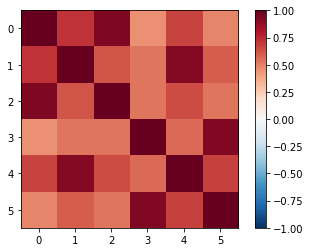

In [ ]:
diag_scores = np.array([np.diag(i) for i in [scores12, scores13, scores21, scores23, scores31, scores32]]).astype(np.float32)
print(diag_scores.shape)
plt.imshow(np.corrcoef(diag_scores), vmin=-1, vmax=1, cmap='RdBu_r')
plt.colorbar()

In [ ]:
### Kmeans clustered responses
kpreds = np.load('230608_kmeans_pred_labels.npy')
for i in range(5):
    select_cells = np.where(kpreds == i)[0]

FileNotFoundError: [Errno 2] No such file or directory: '230608_kmeans_pred_labels.npy'

In [ ]:
print(sorted_args1[-1])
print(sorted_args2[-1])
print(sorted_args3[-1])


[121  35  34  31 122  86  22  99 126  61 103 106   3 105  59  70   4  87
  50 112  85  79 116  93 120  88  96  95 107 109  80 104  77 114 102  75
  58  66  76   1  94  91  14  74  37  15  33  81  49  41  45  71  55  24
  36 115  39 117  97  29  64 108  92  90  56 119  26  43  62  38  32  25
 118  48  84  21  73  44   5  51  13  11  40  27   6  46  72 125   8  17
  18   2  19  47 127  23  68  52  83 123  54 111  57  12   7 100  78  89
  42 129  20  16  67  60  65  82  69  53   0  10  30  98 113  28 110 101
 124  63 128   9]
[ 63  37  36  35  87  99 105  50  43 113  80 120 112  61   3  59  70   4
  86  49 107 124  93 109  71 126  79  14  95  44  94 118  88 121  21  76
  45  39  81  74  64  18   9  30  41  91  75  65 108  31  98   8   6   5
 116  96 122  29 125  85  40 114 104  90   0  26  25  33   2  42 115 117
  48  47  10 119  69  84 102  72  34  46  73  51 129  27  68 127 106 100
  12  56  92  53  11  97  38  60  16  19  52   1  24  28  32  89  62  22
  83 111 103  17  13  23  67  54 

(130, 32)
(130, 32)
1
1 0 0


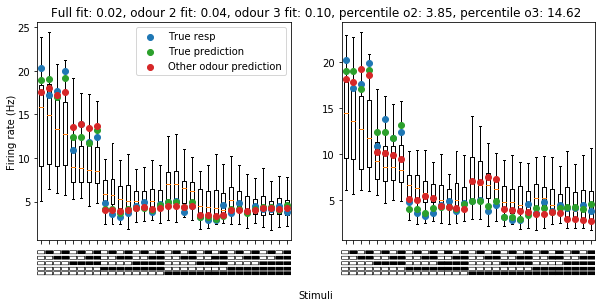

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ui = 95
plot_double_odour_prediction(fig, ax, trues1, preds1, cell_preds12, cell_preds13, diff_models1, scores12, scores13, ui)
ax[0].legend()
print(kpreds[ui])
print(kpreds[ui], kpreds[ui+130], kpreds[ui+260])

(130, 32)


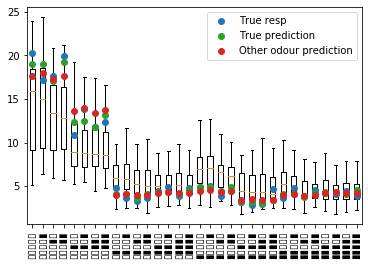

In [ ]:
joint_trues = np.concatenate([trues1, trues2, trues3])
joint_preds = np.concatenate([preds1, preds2, preds3])
joint_cell_preds = np.concatenate([cell_preds12, cell_preds13, cell_preds21, cell_preds23, cell_preds31, cell_preds32])
joint_scores = np.concatenate([scores12, scores13, scores21, scores23, scores31, scores32], axis=1)

joint_diff_models = np.concatenate([diff_models1, diff_models2, diff_models3])


In [ ]:
print(kpreds[:130][sorted_args1[-1]])
print(kpreds[130:260][sorted_args2[-1]])
print(kpreds[260:][sorted_args3[-1]])

[1 0 0 1 3 4 2 0 1 2 1 1 1 1 0 0 2 0 3 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 0 1 3
 0 1 0 1 3 1 1 4 0 0 3 3 1 0 0 0 2 4 1 4 1 4 0 0 1 1 1 0 1 1 2 0 4 1 2 1 0
 1 1 2 2 4 3 1 1 0 1 0 3 1 0 1 2 1 1 1 0 3 1 2 3 1 0 0 4 0 1 4 1 1 4 1 0 0
 2 3 3 3 1 4 3 2 1 0 2 0 2 0 1 0 3 3 4]
[1 4 4 0 0 0 1 3 2 0 1 0 1 2 2 0 1 4 4 3 1 4 0 1 3 1 1 0 0 2 0 1 0 1 0 1 3
 4 3 1 0 0 0 2 2 3 1 1 1 0 0 2 1 3 1 0 0 0 0 0 1 1 0 2 3 1 0 0 2 1 1 1 0 1
 2 1 1 0 0 2 0 1 2 1 3 0 0 3 1 1 0 0 1 4 0 3 2 1 0 1 3 3 0 0 1 3 3 0 3 1 2
 3 0 0 1 0 0 0 0 3 0 3 3 0 0 2 0 0 4 0]
[1 1 0 1 3 1 1 3 3 1 4 3 0 0 1 3 0 0 0 0 2 2 2 2 4 0 1 1 0 1 1 3 0 0 4 0 4
 1 0 3 2 2 2 2 1 0 0 0 1 1 3 2 1 2 1 2 0 0 2 1 3 2 1 0 3 3 0 1 1 1 3 1 0 0
 2 4 0 0 0 1 1 0 0 4 0 0 1 1 4 0 2 0 1 4 0 1 0 1 0 3 1 3 3 2 1 3 3 3 2 1 0
 0 1 0 2 3 2 2 2 2 4 3 1 1 1 1 2 1 2 0]


In [ ]:
print(np.corrcoef([kpreds[:130], kpreds[130:260], kpreds[260:390]]))

[[1.         0.39877533 0.00708884]
 [0.39877533 1.         0.0202851 ]
 [0.00708884 0.0202851  1.        ]]


In [ ]:
print(kpreds[86], kpreds[86+130], kpreds[86+260])

4 4 1


In [ ]:
print(scores12[0, 0])

0.9442067477741916


[164  88  95  35 295 725  85 554 121 404  96 161  50  93 215 605 623 755
  31  94 218 551 336 411 625 664 339 681 465 225 180 724  87 353 310 335
 126 233 354 224 340 495 408 386 291 365 300 348 595 381  91 251  80  76
 347 440 735 355 421 374  81 356 311 776 345 614 220 379 611  79  75 122
 594 641 377 292 109 744 330 684 307 507  34 426 424 375 619 700 601 508
 382 608 436 217 771 256 504 646 765 475 570 223  70 767 438 607 764 516
 232  74 351 200 460 376 367 229 294 484 175 105 505  48 737 204 738  33
 308  41 748 511 464 115 119 341 226 274 749 509 477 235 775 120 205 202
 102  40 592 214 427 754 698 624 380 488  18 148 151 686 745 449 179 133
 615   3 671 466 453 713 489 159 515 239 107  47 565 687  51 758 364 692
 334  21 612  49 769 610 635 441  27 534 478 100  99 319 766 709 634 722
 462 346 494 455 301 768 604 104 117 696  26 359 479 429 627 636  92 622
 502 506 378 629 734 234 695 369 432 352 726 485 752  84 668 385 222  23
  43 581 287 245 293 689 762 271 469 125 281 638 54

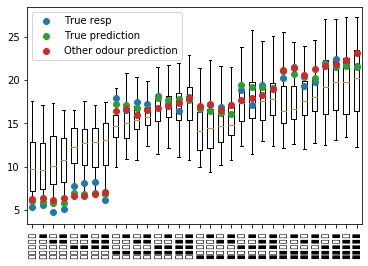

In [ ]:
joint_scores = np.concatenate([np.diag(scores12), np.diag(scores13), np.diag(scores21), np.diag(scores23), np.diag(scores31), np.diag(scores32)], axis=0)
print(np.argsort(joint_scores))
ui = 164-130
plot_other_odour_prediction(trues1, preds1, cell_preds13, ui, legend=True)

In [ ]:
print(len(joint_scores))

130


Text(0, 0.5, 'Firing rate IA (Hz)')

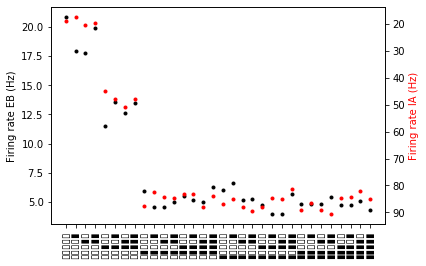

In [ ]:
best_cell = 34#minfracs_args[-1]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(trues1[best_cell], '.', color='k')
ax2 = plt.gca().twinx()
ax2.plot(np.array(trues2[best_cell]), '.', color='r')
ax.set_xticks(range(32))
ax.set_xticklabels(glyphs, rotation=90);
ax2.set_ylim(ax2.get_ylim()[::-1])
ax.set_ylabel('Firing rate EB (Hz)')
ax2.set_ylabel('Firing rate IA (Hz)', color='r')
#plt.plot(cell_preds12[best_cell][best_cell], '.', color='r')


[ 5.5870258  29.49384773]


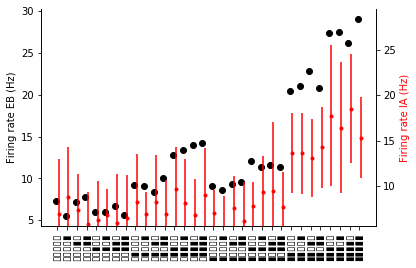

In [16]:

def auto_scale(odour1, odour2, ui):
    data1 = np.array(odour1[ui])
    data2 = np.array(odour2[ui])

    x_data = np.array(range(32))
    init_limits = [0, 100]

    result = minimize(calc_diff, init_limits, args=(data1, data2), method='Nelder-Mead', tol=1e-20, options={'maxiter': 10000})
    return result.x

# Your function to calculate the sum of squared differences
def calc_diff(limits, data1, data2):
    lower, upper = limits
    
    # Rescale data
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    #scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    
    # Calculate sum of squared differences
    diff = np.sum((data1 - scaled_data2)**2)
    return diff

# Initial guesses for lower and upper limits


def plot_multi_odour_response(cell_index, odour1, odour2, ax=None, odour1_std = None, odour2_std = None, legend=False, autoscale=True):
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    
    ax2 = ax.twinx()
    if odour1_std is not None:
        #ax.errorbar(np.arange(0, 64, 2), odour1[cell_index], yerr=odour1_std[cell_index], fmt='.', color='k')
        ax.scatter(np.arange(0, 64, 2), odour1[cell_index], color='k')
        ax2.errorbar(np.arange(0.5, 64.5, 2), np.array(odour2[cell_index]), yerr=odour2_std[cell_index], fmt='.', color='r')
        ax.set_xticks(np.arange(0.25, 64.25, 2))
    else:
        ax.plot(odour1[cell_index], '.', color='k')
        ax2.plot(np.array(odour2[cell_index]), '.', color='r')
        ax.set_xticks(range(32))
    ax.set_xticklabels(glyphs, rotation=90);
    if np.corrcoef(odour1[cell_index], odour2[cell_index])[0, 1] < 0:
        ax2.set_ylim(ax2.get_ylim()[::-1])
    ax.set_ylabel('Firing rate EB (Hz)')
    ax2.set_ylabel('Firing rate IA (Hz)', color='r')
    #ax.spines['right'].set_visible(False)
    #ax2.spines['right'].set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax.spines['top'].set_visible(False)
    if autoscale:
        ylim = auto_scale(odour1, odour2, cell_index)
        print(ylim)
        ax2.set_ylim(ylim)
        #ax.set_ylim([0,1])



plot_multi_odour_response(corr_args[-10], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, autoscale=True)




In [37]:
res = auto_scale(mean_usrt1, mean_usrt2, corr_args[-1])

2.5182388839835856 17.26754459902682
[ 7.15221026  9.76924287 17.2675446  13.45919894 10.24013378  2.51823888
  7.8831551  11.23724423  9.90803702  8.86690441  6.01774795  8.02899704
 13.57249579 10.82100023 12.54548137  2.92592918  7.59518535  8.26080253
  8.55859165  4.6415686   4.8144651   6.57224824  4.98903736  5.47853745
  7.01048036 10.36840137  6.6684326   6.09467815  6.23893366  8.54975408
 11.47864524 11.15727671]


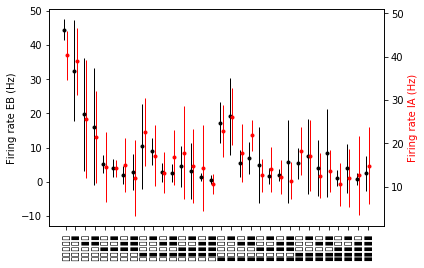

In [20]:
# data1 = np.array(mean_usrt1[corr_args[-1]])
# data2 = np.array(mean_usrt2[corr_args[-1]])
# lower, upper = res
# #plt.plot(mean_usrt1[corr_args[-10]], '.', color='k')
# scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
# scaled_err = (upper - lower) / (np.max(data2) - np.min(data2)) * np.array(std_usrt2[corr_args[-1]])

# plt.errorbar(np.arange(0, 64, 2), data1, yerr=std_usrt1[corr_args[-1]], fmt='o', color='k', linewidth=1)
# plt.errorbar(np.arange(0.5, 64.5, 2), scaled_data2, yerr=scaled_err, fmt='o', color='r', linewidth=1)
# # plt.plot(mean_usrt1[corr_args[-1]], '.', color='r')
# # plt.plot(scaled_data2, '.', color='k')
# ylims = plt.gca().get_ylim()
# ax2 = plt.gca().twinx()
# scaled_ylims = ((np.array(ylims) - lower) * (np.max(data2) - np.min(data2)) / (upper - lower)) + np.min(data2)
# ax2.set_ylim(scaled_ylims)

def plot_multi_odour_response2(cell_index, odour1, odour2, ax=None, odour1_std = None, odour2_std = None, legend=False):
    data1 = np.array(odour1[cell_index])
    data2 = np.array(odour2[cell_index])
    lower, upper = auto_scale(odour1, odour2, cell_index)
    scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    scaled_err = (upper - lower) / (np.max(data2) - np.min(data2)) * np.array(odour2_std[cell_index])

    print(min(scaled_err), max(scaled_err))
    print(scaled_err)
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(111)
    ax.errorbar(np.arange(0, 64, 2), data1, yerr=odour1_std[cell_index], fmt='.', color='k', linewidth=1)
    ax.errorbar(np.arange(0.5, 64.5, 2), scaled_data2, yerr=scaled_err, fmt='.', color='r', linewidth=1)
    ax.set_xticks(np.arange(0.25, 64.25, 2))
    ax.set_xticklabels(glyphs, rotation=90);
    ylims = ax.get_ylim()
    ax2 = ax.twinx()
    scaled_ylims = ((np.array(ylims) - lower) * (np.max(data2) - np.min(data2)) / (upper - lower)) + np.min(data2)
    ax2.set_ylim(scaled_ylims)
    ax2.set_ylabel('Firing rate IA (Hz)', color='r')
    ax.set_ylabel('Firing rate EB (Hz)')

plot_multi_odour_response2(corr_args[-8], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2)
    

# def plot_multi_odour_response2(cell_index, odour1, odour2, ax=None, odour1_std = None, odour2_std = None, legend=False, autoscale=True)):
#     if ax is None:
#         fig = plt.figure()
#         ax = fig.add_subplot(111)
    
#     ax2 = ax.twinx()
#     if odour1_std is not None:
#         ax.errorbar(np.arange(0, 64, 2), odour1[cell_index], yerr=odour1_std[cell_index], fmt='.', color='k')
#         ax2.errorbar(np.arange(0.5, 64.5, 2), np.array(odour2[cell_index]), yerr=odour2_std[cell_index], fmt='.', color='r')
#         ax.set_xticks(np.arange(0.25, 64.25, 2))
#     else:
#         ax.plot(odour1[cell_index], '.', color='k')
#         ax2.plot(np.array(odour2[cell_index]), '.', color='r')
#         ax.set_xticks(range(32))
#     ax.set_xticklabels(glyphs, rotation=90);
#     if np.corrcoef(odour1[cell_index], odour2[cell_index])[0, 1] < 0:
#         ax2.set_ylim(ax2.get_ylim()[::-1])
#     ax.set_ylabel('Firing rate EB (Hz)')
#     ax2.set_ylabel('Firing rate IA (Hz)', color='r')
#     #ax.spines['right'].set_visible(False)
#     #ax2.spines['right'].set_visible(False)
#     ax2.spines['top'].set_visible(False)
#     ax.spines['top'].set_visible(False)
#     if autoscale:
#         ylim = auto_scale(odour1, odour2, cell_index)
#         print(ylim)
#         ax2.set_ylim(ylim)
#         #ax.set_ylim([0,1])

<ErrorbarContainer object of 3 artists>

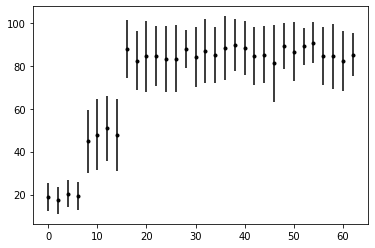

In [ ]:
#plt.plot(mean_usrt2[corr_args[-1]], '.', color='r')
plt.errorbar(np.arange(0, 64, 2), mean_usrt2[corr_args[-1]], yerr=std_usrt2[corr_args[-1]], fmt='.', color='k')

853.919176768692


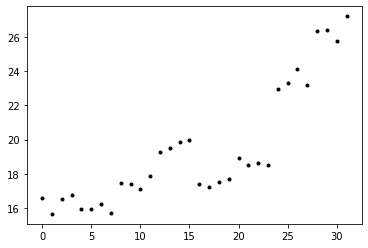

In [ ]:
print(np.sum((data2 - scaled_data1+5)**2))
plt.plot(scaled_data1+10, '.', color='k')

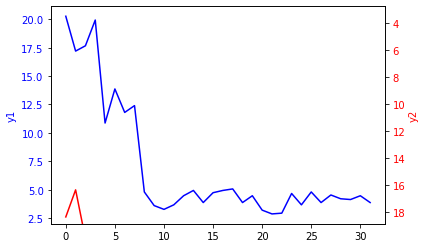

In [ ]:
# This function returns the sum of squares of differences between y1 and y2 
# when y2 is interpreted in a y-range that is shifted and scaled relative to y1's y-range
def objective(params, y1, y2):
    scale, offset = params
    y2_rescaled = (y2 - np.min(y2)) / (np.max(y2) - np.min(y2))  # Map y2 to the unit interval [0, 1]
    y2_transformed = y2_rescaled * scale + offset  # Shift and scale y2
    return np.sum((y1 - y2_transformed) ** 2)

x = np.arange(32)
y1 = mean_usrt1[corr_args[-2]]
y2 = mean_usrt2[corr_args[-2]]
# Initial guess for the scale and offset
params0 = [1, 0]

# Minimize the objective function
res = minimize(objective, params0, args=(y1, y2))

# Get the optimal scale and offset
optimal_scale, optimal_offset = res.x

# Now, plot the data
fig, ax1 = plt.subplots()

# Plot y1 on the first axis
ax1.plot(x, y1, color='blue')
ax1.set_ylabel('y1', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create the second axis
ax2 = ax1.twinx()

# Plot y2 on the second axis
ax2.plot(x, y2, color='red')
ax2.set_ylabel('y2', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Change the y-limits of the second axis based on the scale and offset
y2_rescaled = (y2 - np.min(y2)) / (np.max(y2) - np.min(y2))  # Map y2 to the unit interval [0, 1]
y2_transformed = y2_rescaled * optimal_scale + optimal_offset  # Shift and scale y2
ax2.set_ylim([np.max(y2_transformed), np.min(y2_transformed)])

# Show the plot
plt.show()

<ErrorbarContainer object of 3 artists>

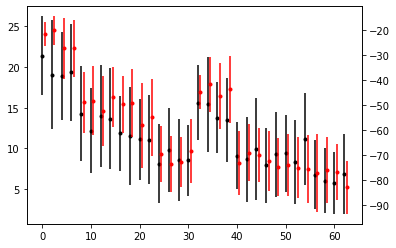

In [ ]:
ui = 7
plt.errorbar(np.arange(0, 64, 2), mean_usrt1[ui], yerr=std_usrt1[ui], fmt='.', color='k')
ax2 = plt.gca().twinx()
ax2.errorbar(np.arange(0.5, 64.3, 2), -np.array(mean_usrt2[ui]), yerr=std_usrt2[ui], color='r', fmt='.')

In [14]:
corrs = [np.corrcoef(i, j)[0, 1] for i, j in zip(mean_usrt1, mean_usrt2)]
print(np.argsort(np.abs(corrs)))
corr_args = np.argsort(np.abs(corrs))

[ 3 51 41 12  4 24  2 63 31 52 49 53 21 44  6 47 22 25 64 10 43 36 16 13
 11 58 15 60 56 23 20  5 55 54 17 62 48  8 59  0 50  1 57 18 45  9 33 26
 14 35 30 46 29 28 42 38 19 65 61 27  7 40 37 32 39 34]


In [ ]:
print()

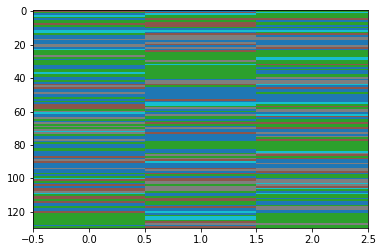

In [ ]:
plt.imshow(kpreds.reshape(130, 3), aspect='auto', cmap='tab10')

54
36
58
55
46
62
42
48
55


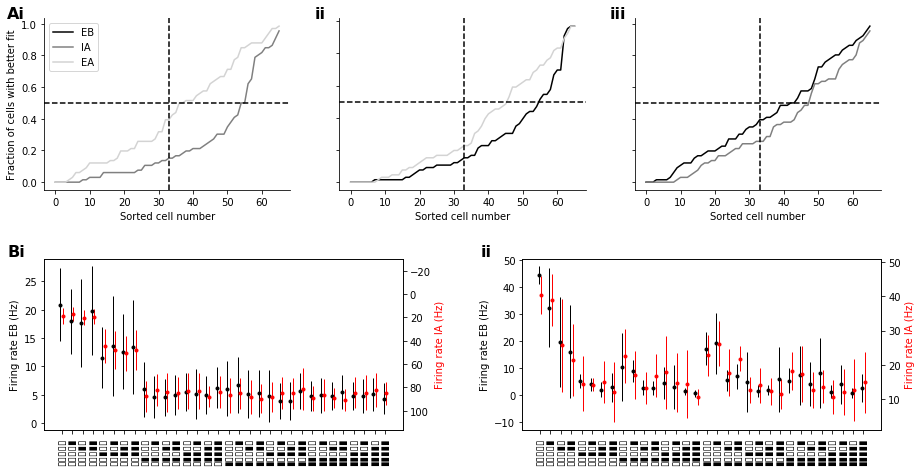

In [40]:
odour_grays = ['k', 'gray', 'lightgray']
fig = plt.figure(figsize=(15, 12))
gs = GridSpec(3, 4, figure=fig, hspace=0.4, wspace=1)
acc_gs = gs[0, :].subgridspec(1, 3)
acc_axs = [fig.add_subplot(i) for i in acc_gs]
acc_axs[0].plot([], color='k', label='EB')
ax0, fracs1, sorted_args1 = plot_score_fracs(scores12, scores13, odour1_label='IA', odour2_label='EA', ax=acc_axs[0], colors=[odour_grays[1], odour_grays[2], 'r'], show_best=False)
ax1, fracs2, sorted_args2 = plot_score_fracs(scores21, scores23, odour1_label='EB', odour2_label='EA', ax=acc_axs[1], colors=[odour_grays[0], odour_grays[2], 'r'], show_best=False)
ax2, fracs3, sorted_args3 = plot_score_fracs(scores31, scores32, odour1_label='EB', odour2_label='IA', ax=acc_axs[2], colors=[odour_grays[0], odour_grays[1], 'r'], show_best=False)
[ax.spines['right'].set_visible(False) for ax in acc_axs]
[ax.spines['top'].set_visible(False) for ax in acc_axs]
[i.set_ylabel('') for i in acc_axs[1:]]
[i.set_yticklabels([]) for i in acc_axs[1:]]
acc_axs[0].legend()
best_response_ax1 = fig.add_subplot(gs[1, 0:2])
best_response_ax2 = fig.add_subplot(gs[1, 2:4])
# best_response_ax3 = fig.add_subplot(gs[1, 2])
# best_response_ax4 = fig.add_subplot(gs[1, 3])
s=15

# plot_other_odour_prediction(trues1, preds1, cell_preds12,minfracs_args[0], ax = best_response_ax1, legend=False, s=s)
# plot_other_odour_prediction(trues1, preds1, cell_preds12,minfracs_args[1], ax = best_response_ax2, legend=False, s=s)
# plot_other_odour_prediction(trues1, preds1, cell_preds12,minfracs_args[2], ax = best_response_ax3, legend=False, s=s)
# plot_other_odour_prediction(trues1, preds1, cell_preds12,minfracs_args[4], ax = best_response_ax4, legend=False, s=s)

plot_multi_odour_response2(corr_args[-1], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=best_response_ax1)
plot_multi_odour_response2(corr_args[-8], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=best_response_ax2)
# plot_multi_odour_response2(corr_args[-2], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=best_response_ax3)
# plot_multi_odour_response2(corr_args[-8], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=best_response_ax4)

# worst_response_ax1 = fig.add_subplot(gs[2, 0])
# worst_response_ax2 = fig.add_subplot(gs[2, 1])
# worst_response_ax3 = fig.add_subplot(gs[2, 2])
# worst_response_ax4 = fig.add_subplot(gs[2, 3])

# plot_multi_odour_response2(corr_args[0], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=worst_response_ax1)
# plot_multi_odour_response2(corr_args[1], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=worst_response_ax2)
# plot_multi_odour_response2(corr_args[2], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=worst_response_ax3)
# plot_multi_odour_response2(corr_args[3], mean_usrt1, mean_usrt2, odour1_std=std_usrt1, odour2_std=std_usrt2, ax=worst_response_ax4)
# plot_other_odour_prediction(trues1, preds1, cell_preds13, minfracs_args[-1], ax = worst_response_ax1, legend=False, s=s)
# plot_other_odour_prediction(trues1, preds1, cell_preds13, minfracs_args[-2], ax = worst_response_ax2, legend=False, s=s)
# plot_other_odour_prediction(trues1, preds1, cell_preds13, minfracs_args[-3], ax = worst_response_ax3, legend=False, s=s)
# plot_other_odour_prediction(trues1, preds1, cell_preds13, minfracs_args[-4], ax = worst_response_ax4, legend=False, s=s)

# pred_axs = [best_response_ax1, best_response_ax2, best_response_ax3, best_response_ax4, worst_response_ax1, worst_response_ax2, worst_response_ax3, worst_response_ax4]
# [ax.spines['right'].set_visible(False) for ax in pred_axs]
# [ax.spines['top'].set_visible(False) for ax in pred_axs]
# best_response_ax1.legend(loc='upper right')
# [ax.set_xticklabels([]) for ax in pred_axs[:4]]
# axes = [*acc_axs, best_response_ax1, best_response_ax2, best_response_ax3, best_response_ax4, worst_response_ax1, worst_response_ax2, worst_response_ax3, worst_response_ax4]
# labels = ['Ai', 'ii', 'iii', 'Bi', 'ii', 'iii', 'iv', 'Ci', 'ii', 'iii', 'iv']
# align_x = [[0, 3, 7], [4, 8], [5, 9], [6, 10]]
# align_y = [[0, 1, 2], [3, 4, 5, 6], [7, 8, 9, 10]]
# label_axes.label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', align_x_fun=np.min, align_y_fun=np.max)
# best_response_ax1.set_ylabel('Spike count')
# worst_response_ax1.set_ylabel('Spike count')
#plot_double_odour_prediction(fig, [best_response_ax11, best_response_ax12], trues1, preds1, cell_preds12, cell_preds13, diff_models1, scores12, scores13, minfracs_args[0])

axes = [*acc_axs, best_response_ax1, best_response_ax2]
labels = ['Ai', 'ii', 'iii', 'Bi', 'ii']
align_x = [[0, 3]]
align_y = [[0, 1, 2], [3, 4]]
dx = [0, -0.02, -0.02, 0, 0]
label_axes.label_axes(axes, labels, align_x=align_x, align_y=align_y, fontsize=16, fontweight='bold', align_x_fun=np.min, align_y_fun=np.max, dx=dx)
plt.savefig('230703_fig7.pdf', bbox_inches='tight')


In [ ]:
print('a')

a


In [ ]:
import numpy as np
from scipy.optimize import minimize

data1 = np.array(mean_usrt1[34])
data2 = np.array(mean_usrt2[34])

x_data = np.array(range(32))

# Your function to calculate the sum of squared differences
def calc_diff(limits):
    lower, upper = limits
    
    # Rescale data
    scaled_data1 = lower + (data1 - np.min(data1))*(upper - lower) / (np.max(data1) - np.min(data1))
    #scaled_data2 = lower + (data2 - np.min(data2))*(upper - lower) / (np.max(data2) - np.min(data2))
    
    # Calculate sum of squared differences
    diff = np.sum((data2 - scaled_data1)**2)
    return diff

# Initial guesses for lower and upper limits
init_limits = [0, 100]

result = minimize(calc_diff, init_limits, method='Nelder-Mead', tol=1e-10)

print(result.x)


[90.73527445 11.66205736]


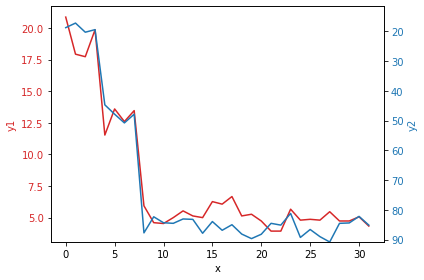

In [ ]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('x')
ax1.set_ylabel('y1', color=color)
ax1.plot(x_data, data1, color=color)
ax1.tick_params(axis='y', labelcolor=color)

#ax1.set_ylim(result.x[0], result.x[1])

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('y2', color=color)  # we already handled the x-label with ax1
ax2.plot(x_data, data2, color=color)
ax2.tick_params(axis='y', labelcolor=color)

ax2.set_ylim(result.x[0], result.x[1])

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [ ]:

from scipy.optimize import minimize




# Function to rescale data to a given range
def rescale_data(data, lower, upper):
    return lower + (data - np.min(data))*(upper - lower) / (np.max(data) - np.min(data))

# Your function to calculate the sum of squared differences
def calc_diff(shift):
    # Rescale data
    scaled_data1 = rescale_data(data1, 0, 1)
    scaled_data2 = rescale_data(data2, shift, 1+shift)
    
    # Calculate sum of squared differences
    diff = np.sum((scaled_data1 - scaled_data2)**2)
    return diff

# Initial guess for shift
init_shift = [0]

result = minimize(calc_diff, init_shift, method='Nelder-Mead')

print(result.x)


[-0.5244375]
